In [1]:
import pandas as pd
import numpy as np 
import math
import sys

from scipy.stats import pearsonr
import matplotlib.pyplot as plt 

import importlib
import smlmodule

from itertools import combinations
from pprint import pprint

"""
https://bmjopen.bmj.com/content/10/9/e039338

We have computed the number of COVID-19 infected people for each province and the infection 
rate based on the number of inhabitants from February 24th to March 13th (the date when the 
lockdown was decided), as reported by the official government website, updated with daily 
frequency.34 The number of PM exceedances were computed between February 9th and February 29th, 
as we had to take into account the maximum lag period of 14 days, which is the average time 
elapsed between the contagion and the first weeks of the Italian epidemic 
(February 24th to March 13th). 

period1 = ['2020-02-09', '2020-02-28'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-24', '2020-03-13']

period2 = ['2020-02-09', '2020-03-06] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-09', '2020-03-21']
period3 = ['2020-08-29', '2020-09-01'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-10-15']
period4 = ['2020-08-29', '2020-10-30'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-11-14']
period5 = ['2020-05-15', '2020-08-15'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-06-01', '2020-09-01']
"""


LIMIT = 0.95

verbose = False
paperpath = "./data/particulate.csv"
agefeatspath = "./data/provinceages.csv"
deprividxpath = "./data/ID11_prov21.xlsx"
tabellecodicipath = "./data/TabelleCodici.xlsx"
copernicopath = "./data/name_region_province_statistics_2020.csv"

__provmaps__ = {
    "bolzano_bozen": "bolzano",
    "bolzanobozen": "bolzano",
    "vibovalentia": "vibo_valentia",
    "laquila": "l_aquila",
    "laspezia": "la_spezia",
    "barlettaandriatrani": "bat",
    "ascolipiceno": "ascoli_piceno",
    "carboniaiglesias": "carbonia",
    "reggioemilia": "reggio_nell_emilia",
    "pesarourbino": "pesaro",
    "monzabrianza": "monza",
    "reggiocalabria": "reggio_di_calabria",
    "forlicesena": "forli",
    "massacarrara": "massa",
    "verbanocusioossola": "verbania",
    "verbano_cusio_ossola": "verbania",
    "massa_carrara": "massa",
    "monza_e_della_brianza": "monza",
    "pesaro_e_urbino": "pesaro",
    "forli__cesena": "forli",
    "bolzano_/_bozen": "bolzano",
    "barletta_andria_trani": "bat",
    "sud_sardegna": "carbonia",
    "forlì_cesena": "forli"
}

pollutantsnames = "avg_wco_period1_2020,"+\
        "avg_wnh3_period1_2020,"+\
        "avg_wnmvoc_period1_2020,"+\
        "avg_wno2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wo3_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wso2_period1_2020," +\
        "sum_wnh3_ex_q75_period1_2020," +\
        "sum_wnmvoc_ex_q75_period1_2020," +\
        "sum_wno2_ex_q75_period1_2020," +\
        "sum_wno_ex_q75_period1_2020," +\
        "sum_wpans_ex_q75_period1_2020," +\
        "sum_wpm10_ex_q75_period1_2020," +\
        "sum_wpm2p5_ex_q75_period1_2020," +\
        "sum_wo3_ex_q75_period1_2020," + \
        "sum_wco_ex_q75_period1_2020," + \
        "sum_wso2_ex_q75_period1_2020"

featurestobeused = "density," + \
        "commutersdensity," + \
        "depriv," + \
        "lat," + \
        "Ratio0200ver65," + \
        "exoverstation," + \
        "avg_wco_period1_2020,"+\
        "avg_wnh3_period1_2020,"+\
        "avg_wnmvoc_period1_2020,"+\
        "avg_wno2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wo3_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wso2_period1_2020"

def filterprovname (inprov):
    low = inprov.lower()
    low = low.rstrip()
    low = low.lstrip()
    low = low.replace(" ", "_")
    low = low.replace("'", "_")
    low = low.replace("-", "_")

    return low

def normalize_provname (indata, provcolumn, verbose):

    dict_data = {}  
    for c in indata.columns:
        if verbose:
            print("  ", c)
        if c != provcolumn:
            dict_data[c] = []
    dict_data["prov"] = []

    for i, row in indata.iterrows():
        for c in indata.columns:    
            if c != provcolumn:
                dict_data[c].append(row[c])
            else:
                low = filterprovname(row[c])
                if low in __provmaps__:
                    low = __provmaps__[low]

                dict_data["prov"].append(low)

    #for v in dict_data:
    #    print(v, " ", len(dict_data[v]))

    data = pd.DataFrame.from_dict(dict_data)

    return data

In [2]:
tc = pd.ExcelFile(tabellecodicipath)

idtoprov = {}
province = tc.parse("Codice Provincia")
for val in province[["Codice Provincia","Nome Provincia"]].values:
    if type(val[1]) != float:
        idtoprov[int(val[0])] = val[1]
        #print(int(val[0]), val[1])

in_datapaper = pd.read_csv(paperpath, sep=";")
in_deprividx =  pd.ExcelFile(deprividxpath).parse("Foglio1")
in_agefeatures = pd.read_csv(agefeatspath)
in_agefeatures = in_agefeatures[in_agefeatures.Population2020 != 0.0]
in_copernico = pd.read_csv(copernicopath)

print("Paper data ")
datapaper = normalize_provname(in_datapaper, "Province", False)
print("Age features ")
agefeatures = normalize_provname(in_agefeatures, "Provincia", False)
print("Copernico data ") 
copernico = normalize_provname(in_copernico, "nome_ita", False)

dict_deprividx = {}
print("DrepivIdx name ")
for c in in_deprividx.columns:
    if verbose:
        print("   ", c)   
    dict_deprividx[c] = []
dict_deprividx["prov"] = []

for i, row in in_deprividx.iterrows():
    id = row["prov21"]
    prov = filterprovname(idtoprov[id])
    
    if prov in __provmaps__:
        prov = __provmaps__[prov]
    
    #print(id, prov)
    dict_deprividx["prov"].append(prov)
    for c in in_deprividx.columns:
        dict_deprividx[c].append(row[c])


deprividx = pd.DataFrame.from_dict(dict_deprividx)       

provincelist = list(set(list(datapaper["prov"].values)) & \
        set(list(deprividx["prov"].values)) & \
        set(list(agefeatures["prov"].values)) &
        set(list(copernico["prov"].values)))

print("Province list: ")
for i, p in enumerate(provincelist):
    print("  ", i+1, " ", p)

Paper data 
Age features 
Copernico data 
DrepivIdx name 
Province list: 
   1   siracusa
   2   milano
   3   savona
   4   bari
   5   pescara
   6   chieti
   7   firenze
   8   bologna
   9   bat
   10   latina
   11   verbania
   12   torino
   13   alessandria
   14   vercelli
   15   taranto
   16   lucca
   17   treviso
   18   grosseto
   19   asti
   20   carbonia
   21   l_aquila
   22   mantova
   23   monza
   24   isernia
   25   sassari
   26   matera
   27   genova
   28   viterbo
   29   terni
   30   foggia
   31   perugia
   32   rovigo
   33   catania
   34   cuneo
   35   palermo
   36   parma
   37   modena
   38   catanzaro
   39   vicenza
   40   ancona
   41   rimini
   42   pesaro
   43   ragusa
   44   rieti
   45   caltanissetta
   46   lecco
   47   oristano
   48   bergamo
   49   lodi
   50   brindisi
   51   cremona
   52   campobasso
   53   livorno
   54   biella
   55   la_spezia
   56   benevento
   57   pavia
   58   novara
   59   ascoli_piceno
   

In [3]:
counter = 0

for prov in provincelist:
    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]
    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 

    #if diff < 5.0 :
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        counter += 1
        print(counter, prov)

ylogpropcasi = []
features_dict = {}

for fn in ("population", "density", "commutersdensity", "depriv", \
    "lat", "Ratio0200ver65","exoverstation"):
    features_dict[fn] = np.zeros(counter, dtype="float64")

for fn in pollutantsnames.split(","):
    features_dict[fn] = np.zeros(counter, dtype="float64")

i = 0 
for idx, prov in enumerate(provincelist):

    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]

    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 
    
    ycasi = cases/popolazione

    #if diff < 5.0:
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        if ycasi == 0.0:
           ylogpropcasi.append(-13.0) 
        else:
            ylogpropcasi.append(math.log(ycasi)) # atural logarithm of different numbers

        selected = copernico[copernico["prov"] == prov]

        features_dict["population"][i] = popolazione
        features_dict["density"][i] = \
                    datapaper[datapaper["prov"] == prov]["Density"].values[0]    
        features_dict["commutersdensity"][i] = \
                    datapaper[datapaper["prov"] == prov]["CommutersDensity"].values[0]       
        features_dict["lat"][i] = \
                    datapaper[datapaper["prov"] == prov]["Lat"].values[0]       
        features_dict["depriv"][i] = \
                    deprividx[deprividx["prov"] == prov]["ID_2011"].values[0]
        #print(idx, prov, agefeatures[agefeatures["prov"] == prov])
        features_dict["Ratio0200ver65"][i] = \
                    agefeatures[agefeatures["prov"] == prov]["Ratio0200ver65"].values[0]

        for fn in pollutantsnames.split(","):
            val = selected[fn].values[0]
            features_dict[fn][i] = val 

        #features_dict["exoverstation"][i] = Exceedances/StationsNum


        i = i + 1

1 siracusa
2 milano
3 savona
4 bari
5 pescara
6 chieti
7 firenze
8 bologna
9 bat
10 latina
11 verbania
12 torino
13 alessandria
14 vercelli
15 taranto
16 lucca
17 treviso
18 grosseto
19 asti
20 l_aquila
21 mantova
22 monza
23 sassari
24 matera
25 genova
26 viterbo
27 terni
28 foggia
29 perugia
30 rovigo
31 catania
32 cuneo
33 palermo
34 parma
35 modena
36 catanzaro
37 vicenza
38 ancona
39 rimini
40 pesaro
41 ragusa
42 rieti
43 caltanissetta
44 lecco
45 oristano
46 bergamo
47 lodi
48 brindisi
49 cremona
50 campobasso
51 livorno
52 biella
53 la_spezia
54 benevento
55 pavia
56 novara
57 ascoli_piceno
58 cagliari
59 massa
60 salerno
61 reggio_di_calabria
62 ferrara
63 teramo
64 venezia
65 pisa
66 pordenone
67 piacenza
68 cosenza
69 varese
70 trento
71 ravenna
72 lecce
73 forli
74 trapani
75 arezzo
76 pistoia
77 bolzano
78 roma
79 caserta
80 potenza
81 padova
82 crotone
83 vibo_valentia
84 imperia
85 avellino
86 siena
87 frosinone
88 agrigento
89 como
90 enna
91 trieste
92 belluno
93 sondri

In [4]:
# nomalize values
new_features_dict = {}
for fn in features_dict:
    #print(fn)
    abs_max = np.amax(np.abs(features_dict[fn]))
    if abs_max == 0.0:
        print (fn, " will be removed ")
        print (features_dict[fn])
    else:
        new_features_dict[fn] = features_dict[fn] * (1.0 / abs_max)

features_dict = new_features_dict

highcorrelated = {}
for i1, v1 in enumerate(features_dict):
    highcorrelated[v1] = []
    for i2, v2 in enumerate(features_dict):
        #if v1 != v2 and i2 > i1:
        if v1 != v2:
            corr, _ = pearsonr(features_dict[v1], features_dict[v2])
            if math.fabs(corr) > LIMIT:
                highcorrelated[v1].append(v2)
                #print(v1, v2, corr)

    #if len(highcorrelated[v1]) > 0:
    #    print(v1)
    #    for fntr in highcorrelated[v1]:
    #        print("   ", fntr)

removedfeatures = []
features = []
for fn in featurestobeused.split(","):
    if fn in features_dict:
        canadd = True
        for fnin in features:
            if fn in highcorrelated[fnin]:
                canadd = False
                break

        if canadd:
            print("Using: %30s"%fn)
            features.append(fn)
        else:
            removedfeatures.append(fn)


print("")
for fn in removedfeatures:
    print("Highly correlated removing %30s"%fn)
    for cf  in highcorrelated[fn]:
        print("     ",cf)
print(" ")

exoverstation  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wo3_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wco_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.

Training set average RMSE:  0.34467  0.02218 
    Test set average RMSE:  0.95925  0.09238 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.34086
                       R2:  0.94683


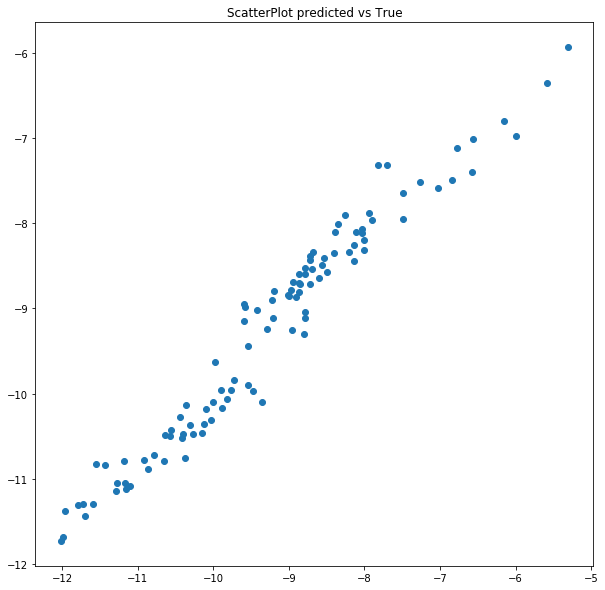

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.02391
Feature:               commutersdensity, Score: 0.01160
Feature:                         depriv, Score: 0.02821
Feature:                            lat, Score: 0.64401
Feature:                 Ratio0200ver65, Score: 0.04983
Feature:           avg_wco_period1_2020, Score: 0.03322
Feature:          avg_wnh3_period1_2020, Score: 0.06865
Feature:           avg_wno_period1_2020, Score: 0.03659
Feature:           avg_wo3_period1_2020, Score: 0.04945
Feature:         avg_wpans_period1_2020, Score: 0.02456
Feature:          avg_wso2_period1_2020, Score: 0.02997


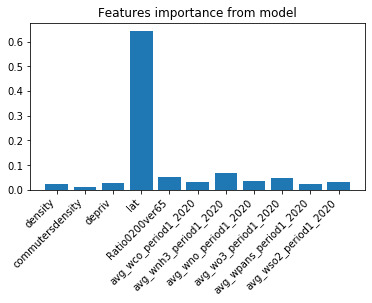

<Figure size 720x720 with 0 Axes>


Features importance from Permutation: 
Feature:                        density, Score: 0.04160
Feature:               commutersdensity, Score: 0.03004
Feature:                         depriv, Score: 0.04786
Feature:                            lat, Score: 2.80059
Feature:                 Ratio0200ver65, Score: 0.10547
Feature:           avg_wco_period1_2020, Score: 0.08909
Feature:          avg_wnh3_period1_2020, Score: 0.16868
Feature:           avg_wno_period1_2020, Score: 0.10061
Feature:           avg_wo3_period1_2020, Score: 0.08056
Feature:         avg_wpans_period1_2020, Score: 0.06225
Feature:          avg_wso2_period1_2020, Score: 0.05068


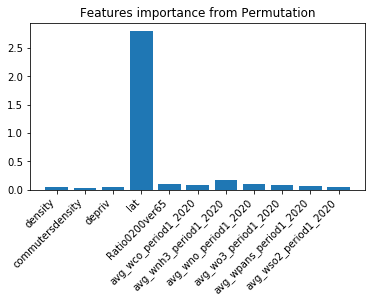

<Figure size 720x720 with 0 Axes>

((0.34467195986852006, 0.02217500560718446),
 (0.959245178425956, 0.09238239886668655),
 0.34086443762301283,
 {'density': 0.011628643608751182,
  'commutersdensity': 0.008396077254637126,
  'depriv': 0.013377268448930507,
  'lat': 0.7828512075803997,
  'Ratio0200ver65': 0.02948120858193502,
  'avg_wco_period1_2020': 0.024902644588634174,
  'avg_wnh3_period1_2020': 0.0471523477485292,
  'avg_wno_period1_2020': 0.028124859019407287,
  'avg_wo3_period1_2020': 0.022517706117079643,
  'avg_wpans_period1_2020': 0.017400770786241686,
  'avg_wso2_period1_2020': 0.01416726626545447})

In [5]:
#finalfeaturestobeused = "density,commutersdensity,exoverstation"
#features = finalfeaturestobeused.split(",")
#listostack = [features_dict[v] for v in features]

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, showplot=True)

In [6]:
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

bestf, bestmse = smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

print(bestf, bestmse)

1  of  1200 MSE:  0.1161885648360528
2  of  1200 MSE:  0.1088523851674074
3  of  1200 MSE:  0.17518934441186737
4  of  1200 MSE:  0.21860225754543786
5  of  1200 MSE:  0.40209437967187733
6  of  1200 MSE:  0.4761267190610462
7  of  1200 MSE:  0.5732806388303763
8  of  1200 MSE:  0.6684234224462581
9  of  1200 MSE:  0.16409936597850175
10  of  1200 MSE:  0.17896914192785557
11  of  1200 MSE:  0.19462698527739974
12  of  1200 MSE:  0.2316639281761432
13  of  1200 MSE:  0.40209437967187733
14  of  1200 MSE:  0.4761267190610462
15  of  1200 MSE:  0.5732806388303763
16  of  1200 MSE:  0.6684234224462581
17  of  1200 MSE:  0.2680255697276379
18  of  1200 MSE:  0.3154651700754155
19  of  1200 MSE:  0.2913727731811324
20  of  1200 MSE:  0.3549986215965956
21  of  1200 MSE:  0.40209437967187733
22  of  1200 MSE:  0.4761267190610462
23  of  1200 MSE:  0.5732806388303763
24  of  1200 MSE:  0.6684234224462581
25  of  1200 MSE:  0.35605894388917514
26  of  1200 MSE:  0.4164560713365575
27  of  1200

{'bootstrap': True,
 'max_depth': 15,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 800,
 'random_state': 1}
Training set average RMSE:  0.34066  0.01938 
    Test set average RMSE:  0.92230  0.10429 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 15,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 800,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.32884
                       R2:  0.95052


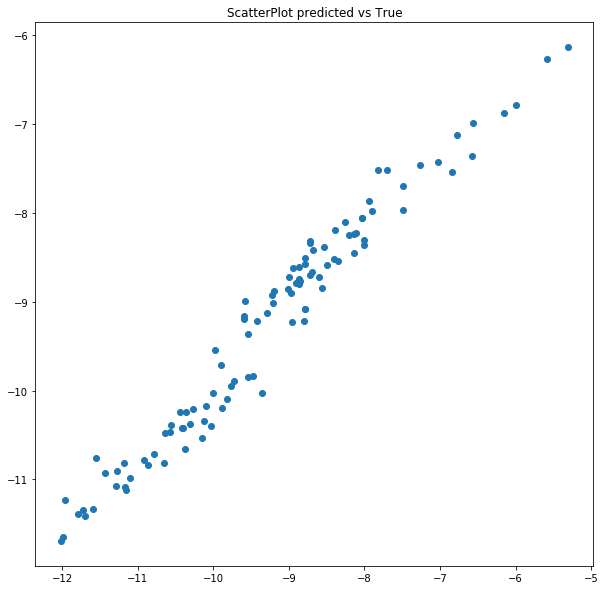

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.02990
Feature:               commutersdensity, Score: 0.15220
Feature:                         depriv, Score: 0.08421
Feature:                            lat, Score: 0.25684
Feature:                 Ratio0200ver65, Score: 0.04852
Feature:           avg_wco_period1_2020, Score: 0.10332
Feature:          avg_wnh3_period1_2020, Score: 0.07667
Feature:           avg_wno_period1_2020, Score: 0.10435
Feature:           avg_wo3_period1_2020, Score: 0.07075
Feature:         avg_wpans_period1_2020, Score: 0.03127
Feature:          avg_wso2_period1_2020, Score: 0.04198


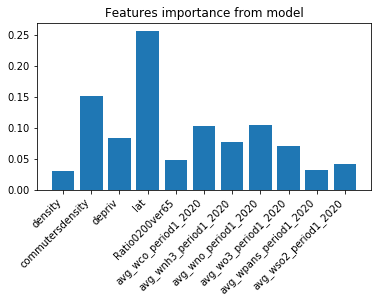

<Figure size 720x720 with 0 Axes>


Features importance from Permutation: 
Feature:                        density, Score: 0.03895
Feature:               commutersdensity, Score: 0.01898
Feature:                         depriv, Score: 0.04210
Feature:                            lat, Score: 2.73125
Feature:                 Ratio0200ver65, Score: 0.11674
Feature:           avg_wco_period1_2020, Score: 0.08426
Feature:          avg_wnh3_period1_2020, Score: 0.14472
Feature:           avg_wno_period1_2020, Score: 0.15551
Feature:           avg_wo3_period1_2020, Score: 0.08742
Feature:         avg_wpans_period1_2020, Score: 0.06157
Feature:          avg_wso2_period1_2020, Score: 0.06839


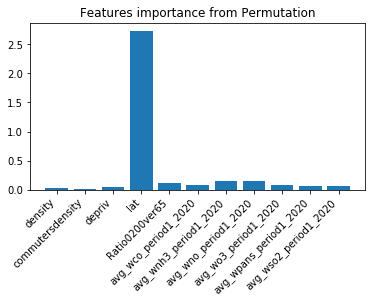

<Figure size 720x720 with 0 Axes>

((0.34066054773478305, 0.019378491418646598),
 (0.9222959739375857, 0.10428827080085408),
 0.3288351605952325,
 {'density': 0.010971828433256683,
  'commutersdensity': 0.0053455188149825975,
  'depriv': 0.011860863263930519,
  'lat': 0.7693902639847212,
  'Ratio0200ver65': 0.03288487826992301,
  'avg_wco_period1_2020': 0.02373482451656617,
  'avg_wnh3_period1_2020': 0.04076674544726844,
  'avg_wno_period1_2020': 0.04380834912141117,
  'avg_wo3_period1_2020': 0.024626465363191342,
  'avg_wpans_period1_2020': 0.01734534558202041,
  'avg_wso2_period1_2020': 0.019264917202728663})

In [7]:
pprint(bestf)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, showplot=True, optimisedparams=bestf)

Training set average RMSE:  0.38825  0.02858 
    Test set average RMSE:  0.99241  0.10651 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.36399
                       R2:  0.93937


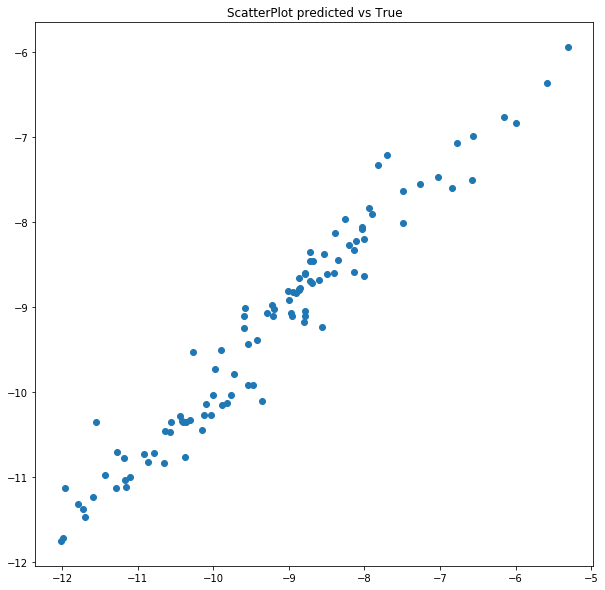

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.02850
Feature:               commutersdensity, Score: 0.48683
Feature:                         depriv, Score: 0.03427
Feature:                 Ratio0200ver65, Score: 0.07944
Feature:           avg_wco_period1_2020, Score: 0.05492
Feature:          avg_wnh3_period1_2020, Score: 0.08959
Feature:           avg_wno_period1_2020, Score: 0.09013
Feature:           avg_wo3_period1_2020, Score: 0.06004
Feature:         avg_wpans_period1_2020, Score: 0.03700
Feature:          avg_wso2_period1_2020, Score: 0.03928


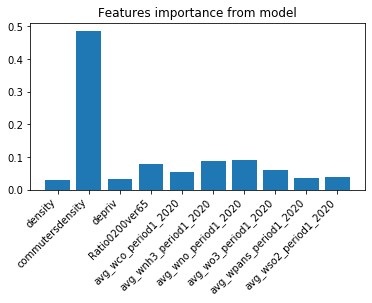

<Figure size 720x720 with 0 Axes>


Features importance from Permutation: 
Feature:                        density, Score: 0.04404
Feature:               commutersdensity, Score: 1.71760
Feature:                         depriv, Score: 0.04504
Feature:                 Ratio0200ver65, Score: 0.19528
Feature:           avg_wco_period1_2020, Score: 0.12889
Feature:          avg_wnh3_period1_2020, Score: 0.20338
Feature:           avg_wno_period1_2020, Score: 0.24827
Feature:           avg_wo3_period1_2020, Score: 0.11060
Feature:         avg_wpans_period1_2020, Score: 0.08539
Feature:          avg_wso2_period1_2020, Score: 0.08092


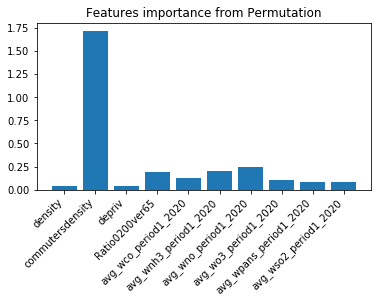

<Figure size 720x720 with 0 Axes>

((0.38824524950937955, 0.028582059143777937),
 (0.9924092876886711, 0.10650586286201058),
 0.36398797576958153,
 {'density': 0.015402101274274736,
  'commutersdensity': 0.6006798460700759,
  'depriv': 0.015752887247852253,
  'Ratio0200ver65': 0.06829460918929778,
  'avg_wco_period1_2020': 0.045076981921179766,
  'avg_wnh3_period1_2020': 0.07112533139669447,
  'avg_wno_period1_2020': 0.08682573138968569,
  'avg_wo3_period1_2020': 0.03868027210766792,
  'avg_wpans_period1_2020': 0.029862281147204614,
  'avg_wso2_period1_2020': 0.02829995825606681})

In [8]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, showplot=True)

In [10]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

bestf, bestmse = smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

print(bestf, bestmse)

1  of  1200 MSE:  0.13248724650483748
2  of  1200 MSE:  0.1337641715540919
3  of  1200 MSE:  0.20305223512291068
4  of  1200 MSE:  0.24726706372101606
5  of  1200 MSE:  0.4823876734436408
6  of  1200 MSE:  0.5620553921428796
7  of  1200 MSE:  0.7111838802102114
8  of  1200 MSE:  0.7745533131821083
9  of  1200 MSE:  0.18972619888807019
10  of  1200 MSE:  0.21348290020932262
11  of  1200 MSE:  0.22264122212889875
12  of  1200 MSE:  0.27305815134203476
13  of  1200 MSE:  0.4823876734436408
14  of  1200 MSE:  0.5620553921428796
15  of  1200 MSE:  0.7111838802102114
16  of  1200 MSE:  0.7745533131821083
17  of  1200 MSE:  0.3226196137296112
18  of  1200 MSE:  0.3840643502450066
19  of  1200 MSE:  0.3543753530314469
20  of  1200 MSE:  0.42026634772198646
21  of  1200 MSE:  0.4823876734436408
22  of  1200 MSE:  0.5620553921428796
23  of  1200 MSE:  0.7111838802102114
24  of  1200 MSE:  0.7745533131821083
25  of  1200 MSE:  0.43661961953383016
26  of  1200 MSE:  0.49700621066635187
27  of  120

Training set average RMSE:  0.36511  0.02089 
    Test set average RMSE:  0.99062  0.09998 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 15,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 800,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.35489
                       R2:  0.94237


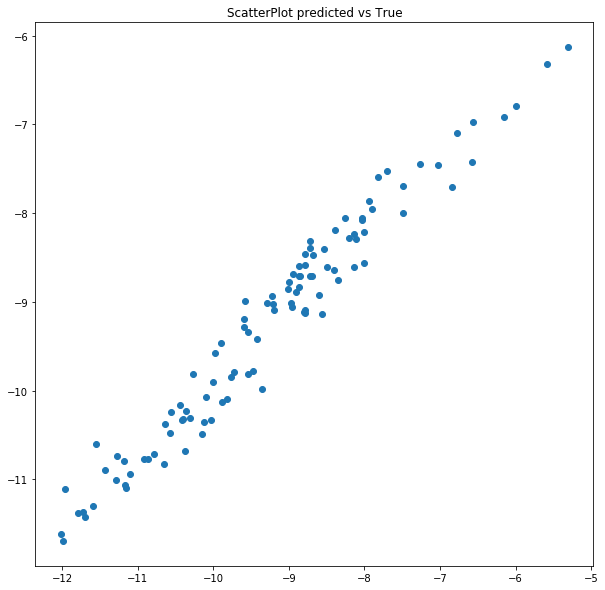

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.03947
Feature:               commutersdensity, Score: 0.24586
Feature:                         depriv, Score: 0.11342
Feature:                 Ratio0200ver65, Score: 0.05852
Feature:           avg_wco_period1_2020, Score: 0.12652
Feature:          avg_wnh3_period1_2020, Score: 0.09321
Feature:           avg_wno_period1_2020, Score: 0.14699
Feature:           avg_wo3_period1_2020, Score: 0.08159
Feature:         avg_wpans_period1_2020, Score: 0.04235
Feature:          avg_wso2_period1_2020, Score: 0.05208


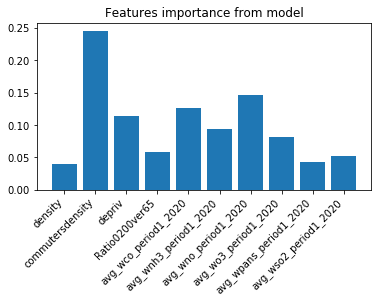

<Figure size 720x720 with 0 Axes>


Features importance from Permutation: 
Feature:                        density, Score: 0.05215
Feature:               commutersdensity, Score: 1.59107
Feature:                         depriv, Score: 0.05372
Feature:                 Ratio0200ver65, Score: 0.20623
Feature:           avg_wco_period1_2020, Score: 0.16903
Feature:          avg_wnh3_period1_2020, Score: 0.16537
Feature:           avg_wno_period1_2020, Score: 0.19959
Feature:           avg_wo3_period1_2020, Score: 0.10904
Feature:         avg_wpans_period1_2020, Score: 0.09307
Feature:          avg_wso2_period1_2020, Score: 0.07683


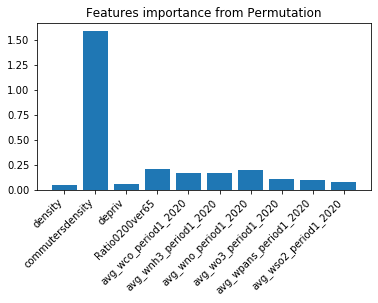

<Figure size 720x720 with 0 Axes>

((0.3651087741816734, 0.020893947514742883),
 (0.9906222522246969, 0.09998048344816475),
 0.35488511164321096,
 {'density': 0.019201719116360035,
  'commutersdensity': 0.5857911719681606,
  'depriv': 0.0197778966126191,
  'Ratio0200ver65': 0.07593012497006081,
  'avg_wco_period1_2020': 0.06223133398867371,
  'avg_wnh3_period1_2020': 0.060886146223745156,
  'avg_wno_period1_2020': 0.07348328152241919,
  'avg_wo3_period1_2020': 0.040144989226076004,
  'avg_wpans_period1_2020': 0.034266038244149984,
  'avg_wso2_period1_2020': 0.028287298127735467})

In [12]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, showplot=True, optimisedparams=bestf)

Training set average RMSE:  0.39942  0.03027 
    Test set average RMSE:  1.08446  0.10514 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.38023
                       R2:  0.93384


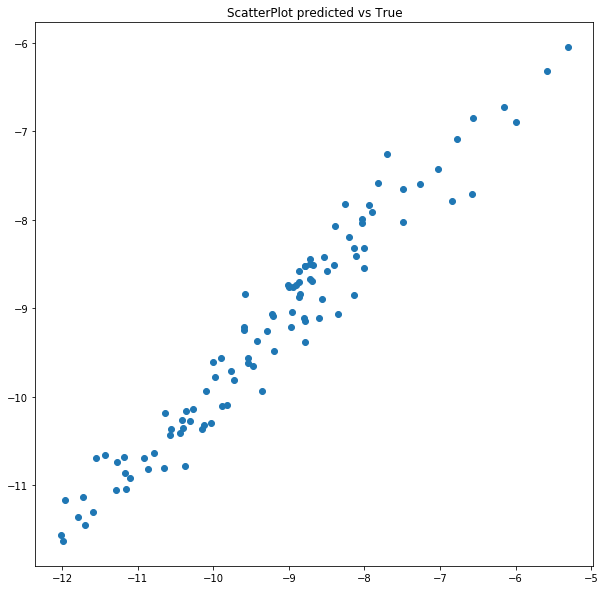

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.03293
Feature:                         depriv, Score: 0.20159
Feature:                 Ratio0200ver65, Score: 0.08699
Feature:           avg_wco_period1_2020, Score: 0.10695
Feature:          avg_wnh3_period1_2020, Score: 0.12056
Feature:           avg_wno_period1_2020, Score: 0.26538
Feature:           avg_wo3_period1_2020, Score: 0.06636
Feature:         avg_wpans_period1_2020, Score: 0.06084
Feature:          avg_wso2_period1_2020, Score: 0.05841


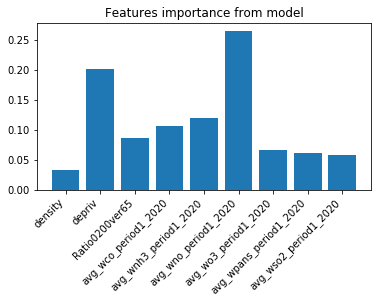

<Figure size 720x720 with 0 Axes>


Features importance from Permutation: 
Feature:                        density, Score: 0.04927
Feature:                         depriv, Score: 0.57838
Feature:                 Ratio0200ver65, Score: 0.14801
Feature:           avg_wco_period1_2020, Score: 0.19291
Feature:          avg_wnh3_period1_2020, Score: 0.31196
Feature:           avg_wno_period1_2020, Score: 0.63179
Feature:           avg_wo3_period1_2020, Score: 0.14438
Feature:         avg_wpans_period1_2020, Score: 0.14655
Feature:          avg_wso2_period1_2020, Score: 0.11755


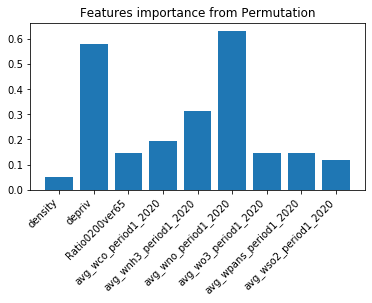

<Figure size 720x720 with 0 Axes>

((0.39942429720716716, 0.030270102258801574),
 (1.0844551224526489, 0.10514113136199643),
 0.38023192496346203,
 {'density': 0.021231731265398027,
  'depriv': 0.24921392260181158,
  'Ratio0200ver65': 0.0637735815204151,
  'avg_wco_period1_2020': 0.08312236963418557,
  'avg_wnh3_period1_2020': 0.1344180319945412,
  'avg_wno_period1_2020': 0.27222796676432653,
  'avg_wo3_period1_2020': 0.062211980228429845,
  'avg_wpans_period1_2020': 0.06314773577127086,
  'avg_wso2_period1_2020': 0.05065268021962122})

In [13]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, showplot=True)

In [14]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

bestf, bestmse = smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

print(bestf, bestmse)

1  of  1200 MSE:  0.14457631676141983
2  of  1200 MSE:  0.13983247274600769
3  of  1200 MSE:  0.22224224349331564
4  of  1200 MSE:  0.25716723971653743
5  of  1200 MSE:  0.5344910195682789
6  of  1200 MSE:  0.6111358289103014
7  of  1200 MSE:  0.8015868960479189
8  of  1200 MSE:  0.8635328634859195
9  of  1200 MSE:  0.21032988150238419
10  of  1200 MSE:  0.22436791957402955
11  of  1200 MSE:  0.2458024858733632
12  of  1200 MSE:  0.28752899357092826
13  of  1200 MSE:  0.5344910195682789
14  of  1200 MSE:  0.6111358289103014
15  of  1200 MSE:  0.8015868960479189
16  of  1200 MSE:  0.8635328634859195
17  of  1200 MSE:  0.343684241543049
18  of  1200 MSE:  0.39180917654770764
19  of  1200 MSE:  0.3822274564378309
20  of  1200 MSE:  0.442004115964323
21  of  1200 MSE:  0.5344910195682789
22  of  1200 MSE:  0.6111358289103014
23  of  1200 MSE:  0.8015868960479189
24  of  1200 MSE:  0.8635328634859195
25  of  1200 MSE:  0.4744986665228861
26  of  1200 MSE:  0.5272456175771767
27  of  1200 MS

Training set average RMSE:  0.37899  0.02919 
    Test set average RMSE:  1.07502  0.11621 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 15,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 800,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.36654
                       R2:  0.93852


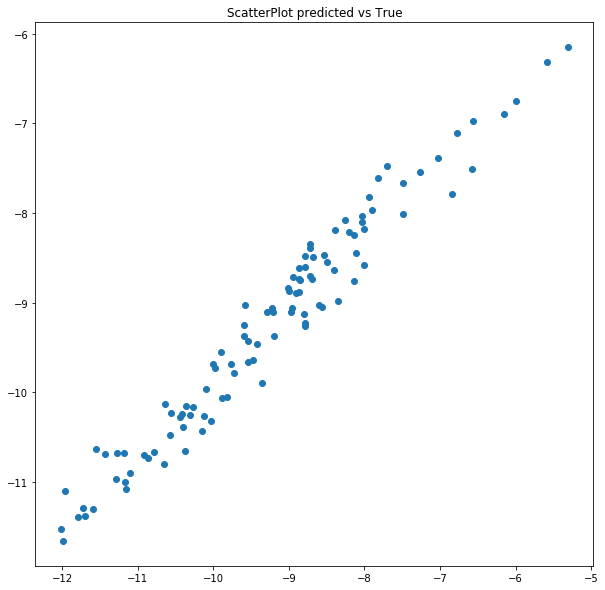

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.04565
Feature:                         depriv, Score: 0.16673
Feature:                 Ratio0200ver65, Score: 0.07530
Feature:           avg_wco_period1_2020, Score: 0.16808
Feature:          avg_wnh3_period1_2020, Score: 0.12819
Feature:           avg_wno_period1_2020, Score: 0.18318
Feature:           avg_wo3_period1_2020, Score: 0.10864
Feature:         avg_wpans_period1_2020, Score: 0.05669
Feature:          avg_wso2_period1_2020, Score: 0.06755


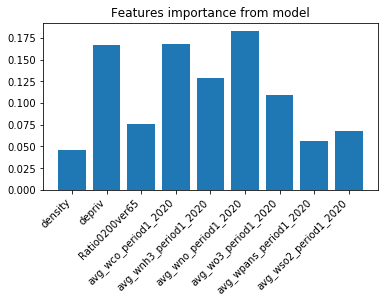

<Figure size 720x720 with 0 Axes>


Features importance from Permutation: 
Feature:                        density, Score: 0.04396
Feature:                         depriv, Score: 0.52314
Feature:                 Ratio0200ver65, Score: 0.11032
Feature:           avg_wco_period1_2020, Score: 0.25575
Feature:          avg_wnh3_period1_2020, Score: 0.24151
Feature:           avg_wno_period1_2020, Score: 0.70502
Feature:           avg_wo3_period1_2020, Score: 0.16567
Feature:         avg_wpans_period1_2020, Score: 0.15258
Feature:          avg_wso2_period1_2020, Score: 0.12231


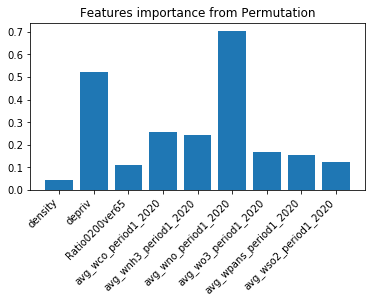

<Figure size 720x720 with 0 Axes>

((0.3789867343195887, 0.029186557406525284),
 (1.0750167314300136, 0.11620983406340121),
 0.36653741965931624,
 {'density': 0.01894815564260955,
  'depriv': 0.2254649029910538,
  'Ratio0200ver65': 0.04754532921669033,
  'avg_wco_period1_2020': 0.11022569789579635,
  'avg_wnh3_period1_2020': 0.10408623348248382,
  'avg_wno_period1_2020': 0.30385550174704484,
  'avg_wo3_period1_2020': 0.07140144192521876,
  'avg_wpans_period1_2020': 0.06575991185614383,
  'avg_wso2_period1_2020': 0.052712825242958825})

In [15]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, showplot=True, optimisedparams=bestf)